 Problem 1: Suppose that an agent is situated in the 4x3 environment as shown in Figure 1.  Beginning in the start state, it must choose an action at each time step.  The interaction with the environment terminates when the agent reaches one of the goal states, marked +1 or -1.  We assume that the environment is fully observable, so that the agent always knows where it is.  You may decide to take the following four actions in every state:  Up, Down, Left and Right.  However, the environment is stochastic, that means the action that you take may not lead you to the desired state.  Each action achieves the intended effect with probability 0.8, but the rest of the time, the action moves the agent at right angles to the intended direction with equal probabilities.  Furthermore, if the agent bumps into a wall, it stays in the same square.  The immediate reward for moving to any state (s) except for the terminal states S+ is r(s)= -0.04.  And the reward for moving to terminal states is +1 and -1 respectively.  Find the value function corresponding to the optimal policy using value iteration.  

Find the value functions corresponding optimal policy for the following:
r(s)=-2
r(s)=0.1
r(s)=0.02
r(s)=1


In [ ]:
import random
from collections import defaultdict

import numpy as np

# from utils import vector_add, orientations, turn_right, turn_left
import operator

def vector_add(a, b):
    """Component-wise addition of two vectors."""
    return tuple(map(operator.add, a, b))

orientations = EAST, NORTH, WEST, SOUTH = [(1, 0), (0, 1), (-1, 0), (0, -1)]
turns = LEFT, RIGHT = (+1, -1)

def turn_heading(heading, inc, headings=orientations):
    #
    # print("AFTER TURN")
    # print(headings[(headings.index(heading) + inc) % len(headings)])
    return headings[(headings.index(heading) + inc) % len(headings)]


def turn_right(heading):
    # print(heading)
    # print("RIGHT")
    return turn_heading(heading, RIGHT)


def turn_left(heading):
    # print(heading)
    # print("LEFT")
    return turn_heading(heading, LEFT)


class MDP:

    def __init__(self, init, actlist, terminals, transitions=None, reward=None, states=None, gamma=0.9):
        if not (0 < gamma <= 1):
            raise ValueError("An MDP must have 0 < gamma <= 1")

        # collect states from transitions table if not passed.
        self.states = states or self.get_states_from_transitions(transitions)

        self.init = init

        if isinstance(actlist, list):
            # if actlist is a list, all states have the same actions
            self.actlist = actlist

        elif isinstance(actlist, dict):
            # if actlist is a dict, different actions for each state
            self.actlist = actlist

        self.terminals = terminals
        self.transitions = transitions or {}
        if not self.transitions:
            print("Warning: Transition table is empty.")

        self.gamma = gamma

        self.reward = reward or {s: 0 for s in self.states}

        # self.check_consistency()

    def R(self, state):
        """Return a numeric reward for this state."""

        return self.reward[state]

    def T(self, state, action):
        """Transition model. From a state and an action, return a list
        of (probability, result-state) pairs."""

        if not self.transitions:
            raise ValueError("Transition model is missing")
        else:
            return self.transitions[state][action]

    def actions(self, state):
        """Return a list of actions that can be performed in this state. By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""

        if state in self.terminals:
            return [None]
        else:
            return self.actlist

    def get_states_from_transitions(self, transitions):
        if isinstance(transitions, dict):
            s1 = set(transitions.keys())
            s2 = set(tr[1] for actions in transitions.values()
                     for effects in actions.values()
                     for tr in effects)
            return s1.union(s2)
        else:
            print('Could not retrieve states from transitions')
            return None

    def check_consistency(self):

        # check that all states in transitions are valid
        assert set(self.states) == self.get_states_from_transitions(self.transitions)

        # check that init is a valid state
        assert self.init in self.states

        # check reward for each state
        assert set(self.reward.keys()) == set(self.states)

        # check that all terminals are valid states
        assert all(t in self.states for t in self.terminals)

        # check that probability distributions for all actions sum to 1
        for s1, actions in self.transitions.items():
            for a in actions.keys():
                s = 0
                for o in actions[a]:
                    s += o[0]
                assert abs(s - 1) < 0.001



class GridMDP(MDP):
    """A two-dimensional grid MDP, as in [Figure 17.1]. All you have to do is
    specify the grid as a list of lists of rewards; use None for an obstacle
    (unreachable state). Also, you should specify the terminal states.
    An action is an (x, y) unit vector; e.g. (1, 0) means move east."""

    def __init__(self, grid, terminals, init=(0, 0), gamma=0.9):
        grid.reverse()  # because we want row 0 on bottom, not on top
        reward = {}
        states = set()
        self.rows = len(grid)
        self.cols = len(grid[0])
        self.grid = grid
        for x in range(self.cols):
            for y in range(self.rows):
                if grid[y][x]:
                    states.add((x, y))
                    reward[(x, y)] = grid[y][x]
        self.states = states
        actlist = orientations
        # print(actlist)  
        transitions = {}
        for s in states:
            transitions[s] = {}
            for a in actlist:
                transitions[s][a] = self.calculate_T(s, a)
                print(s, a)
                print( transitions[s][a])
                print("\n")
        print(transitions)
        MDP.__init__(self, init, actlist=actlist,
                     terminals=terminals, transitions=transitions,
                     reward=reward, states=states, gamma=gamma)

    def calculate_T(self, state, action):
        if action:
            return [(0.8, self.go(state, action)),
                    (0.1, self.go(state, turn_right(action))),
                    (0.1, self.go(state, turn_left(action)))]
        else:
            return [(0.0, state)]

    def T(self, state, action):
        return self.transitions[state][action] if action else [(0.0, state)]

    def go(self, state, direction):
        """Return the state that results from going in this direction."""

        state1 = vector_add(state, direction)
        return state1 if state1 in self.states else state

    def to_grid(self, mapping):
        """Convert a mapping from (x, y) to v into a [[..., v, ...]] grid."""

        return list(reversed([[mapping.get((x, y), None)
                               for x in range(self.cols)]
                              for y in range(self.rows)]))

    def to_arrows(self, policy):
        chars = {(1, 0): 'R', (0, 1): 'U', (-1, 0): 'L', (0, -1): 'D', None: 'O'}
        return self.to_grid({s: chars[a] for (s, a) in policy.items()})


# ______________________________________________________________________________


""" [Figure 17.1]
A 4x3 grid environment that presents the agent with a sequential decision problem.
"""

sequential_decision_environment = GridMDP([[-0.04, -0.04, -0.04, +1],
                                           [-0.04, None, -0.04, -1],
                                           [-0.04, -0.04, -0.04, -0.04]],
                                          terminals=[(3, 2), (3, 1)])


#plot utilities
def plot_utilities(mdp, U):
    grid = mdp.to_grid(U)
    for row in grid:
        print(row)

#plot policy

def plot_policy(mdp, policy):
    grid = mdp.to_arrows(policy)
    for row in grid:
        print(row)
#plot for every iteration
def plot_utilities(mdp, U):
    grid = mdp.to_grid(U)
    for row in grid:
        print(row)
  
# ______________________________________________________________________________


def value_iteration(mdp, epsilon=0.001):
    """Solving an MDP by value iteration. [Figure 17.4]"""

    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    while True:
        U = U1.copy()
        delta = 0
        for s in mdp.states:
            U1[s] = R(s) + gamma * max(sum(p * U[s1] for (p, s1) in T(s, a))
                                       for a in mdp.actions(s))
            delta = max(delta, abs(U1[s] - U[s]))
        if delta <= epsilon * (1 - gamma) / gamma:
            return U


def best_policy(mdp, U):
    """Given an MDP and a utility function U, determine the best policy,
    as a mapping from state to action. [Equation 17.4]"""

    pi = {}
    for s in mdp.states:
        pi[s] = max(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
    return pi


def expected_utility(a, s, U, mdp):
    """The expected utility of doing a in state s, according to the MDP and U."""

    return sum(p * U[s1] for (p, s1) in mdp.T(s, a))

# ______________________________________________________________________________

value_iteration(sequential_decision_environment, epsilon=0.001)


(0, 1) (1, 0)
[(0.8, (0, 1)), (0.1, (0, 0)), (0.1, (0, 2))]


(0, 1) (0, 1)
[(0.8, (0, 2)), (0.1, (0, 1)), (0.1, (0, 1))]


(0, 1) (-1, 0)
[(0.8, (0, 1)), (0.1, (0, 2)), (0.1, (0, 0))]


(0, 1) (0, -1)
[(0.8, (0, 0)), (0.1, (0, 1)), (0.1, (0, 1))]


(1, 2) (1, 0)
[(0.8, (2, 2)), (0.1, (1, 2)), (0.1, (1, 2))]


(1, 2) (0, 1)
[(0.8, (1, 2)), (0.1, (2, 2)), (0.1, (0, 2))]


(1, 2) (-1, 0)
[(0.8, (0, 2)), (0.1, (1, 2)), (0.1, (1, 2))]


(1, 2) (0, -1)
[(0.8, (1, 2)), (0.1, (0, 2)), (0.1, (2, 2))]


(2, 1) (1, 0)
[(0.8, (3, 1)), (0.1, (2, 0)), (0.1, (2, 2))]


(2, 1) (0, 1)
[(0.8, (2, 2)), (0.1, (3, 1)), (0.1, (2, 1))]


(2, 1) (-1, 0)
[(0.8, (2, 1)), (0.1, (2, 2)), (0.1, (2, 0))]


(2, 1) (0, -1)
[(0.8, (2, 0)), (0.1, (2, 1)), (0.1, (3, 1))]


(0, 0) (1, 0)
[(0.8, (1, 0)), (0.1, (0, 0)), (0.1, (0, 1))]


(0, 0) (0, 1)
[(0.8, (0, 1)), (0.1, (1, 0)), (0.1, (0, 0))]


(0, 0) (-1, 0)
[(0.8, (0, 0)), (0.1, (0, 1)), (0.1, (0, 0))]


(0, 0) (0, -1)
[(0.8, (0, 0)), (0.1, (0, 0)), (0.1, (1, 0))]




{(0, 1): 0.3984432178350045,
 (1, 2): 0.649585681261095,
 (2, 1): 0.48644001739269643,
 (0, 0): 0.2962883154554812,
 (3, 1): -1.0,
 (2, 0): 0.3447542300124158,
 (3, 0): 0.12987274656746342,
 (0, 2): 0.5093943765842497,
 (2, 2): 0.7953620878466678,
 (1, 0): 0.25386699846479516,
 (3, 2): 1.0}

In [ ]:
plot_utilities(sequential_decision_environment, value_iteration(sequential_decision_environment, epsilon=0.001))


[0.5093943765842497, 0.649585681261095, 0.7953620878466678, 1.0]
[0.3984432178350045, None, 0.48644001739269643, -1.0]
[0.2962883154554812, 0.25386699846479516, 0.3447542300124158, 0.12987274656746342]


In [ ]:
plot_policy(sequential_decision_environment, best_policy(sequential_decision_environment, value_iteration(sequential_decision_environment, epsilon=0.001)))


['R', 'R', 'R', 'O']
['U', None, 'U', 'O']
['U', 'R', 'U', 'L']


In [ ]:
sequential_decision_environment = GridMDP([[-2, -2, -2, +1],
                                           [-2, None, -2, -1],
                                           [-2, -2, -2, -2]],
                                          terminals=[(3, 2), (3, 1)])
value_iteration(sequential_decision_environment, epsilon=0.001)


{(0, 1): -7.800889843339212,
 (1, 2): -3.9653713444494914,
 (2, 1): -3.3543488275581286,
 (0, 0): -8.587953590425572,
 (3, 1): -1.0,
 (2, 0): -5.309991298022604,
 (3, 0): -3.5141734193811547,
 (0, 2): -6.106717915457216,
 (2, 2): -1.7383417662674585,
 (1, 0): -7.101435103973977,
 (3, 2): 1.0}

In [ ]:
plot_utilities(sequential_decision_environment, value_iteration(sequential_decision_environment, epsilon=0.001))


[-6.106717915457216, -3.9653713444494914, -1.7383417662674585, 1.0]
[-7.800889843339212, None, -3.3543488275581286, -1.0]
[-8.587953590425572, -7.101435103973977, -5.309991298022604, -3.5141734193811547]


In [ ]:
plot_policy(sequential_decision_environment, best_policy(sequential_decision_environment, value_iteration(sequential_decision_environment, epsilon=0.001)))


['R', 'R', 'R', 'O']
['U', None, 'R', 'O']
['R', 'R', 'R', 'U']


In [ ]:
sequential_decision_environment = GridMDP([[0.1, 0.1, 0.1, +1],
                                           [0.1, None, 0.1, -1],
                                           [0.1, 0.1, 0.1, 0.1]],
                                          terminals=[(3, 2), (3, 1)])
value_iteration(sequential_decision_environment, epsilon=0.001)


{(0, 1): 0.9999899925828089,
 (1, 2): 0.999993331397728,
 (2, 1): 0.9999577777706711,
 (0, 0): 0.9999875459240295,
 (3, 1): -1.0,
 (2, 0): 0.9999787337320681,
 (3, 0): 0.9994791585041776,
 (0, 2): 0.9999917011356055,
 (2, 2): 0.9999944696344899,
 (1, 0): 0.999984982429827,
 (3, 2): 1.0}

In [ ]:
plot_utilities(sequential_decision_environment, value_iteration(sequential_decision_environment, epsilon=0.001))


[0.9999917011356055, 0.999993331397728, 0.9999944696344899, 1.0]
[0.9999899925828089, None, 0.9999577777706711, -1.0]
[0.9999875459240295, 0.999984982429827, 0.9999787337320681, 0.9994791585041776]


In [ ]:
plot_policy(sequential_decision_environment, best_policy(sequential_decision_environment, value_iteration(sequential_decision_environment, epsilon=0.001)))


['R', 'R', 'R', 'O']
['U', None, 'L', 'O']
['U', 'L', 'L', 'D']


In [ ]:
sequential_decision_environment = GridMDP([[0.02, 0.02, 0.02, +1],
                                           [0.02, None, 0.02, -1],
                                           [0.02, 0.02, 0.02, 0.02]],
                                          terminals=[(3, 2), (3, 1)])
value_iteration(sequential_decision_environment, epsilon=0.001)

{(0, 1): 0.6502160511064405,
 (1, 2): 0.7917770400021317,
 (2, 1): 0.6145683217603358,
 (0, 0): 0.5900903321492852,
 (3, 1): -1.0,
 (2, 0): 0.5439198685342982,
 (3, 0): 0.36238786411896956,
 (0, 2): 0.7127460585910986,
 (2, 2): 0.8739682955586027,
 (1, 0): 0.542518326037784,
 (3, 2): 1.0}

In [ ]:
plot_utilities(sequential_decision_environment, value_iteration(sequential_decision_environment, epsilon=0.001))


[0.7127460585910986, 0.7917770400021317, 0.8739682955586027, 1.0]
[0.6502160511064405, None, 0.6145683217603358, -1.0]
[0.5900903321492852, 0.542518326037784, 0.5439198685342982, 0.36238786411896956]


In [ ]:
plot_policy(sequential_decision_environment, best_policy(sequential_decision_environment, value_iteration(sequential_decision_environment, epsilon=0.001)))


['R', 'R', 'R', 'O']
['U', None, 'U', 'O']
['U', 'L', 'U', 'D']


In [ ]:
sequential_decision_environment = GridMDP([[1, 1, 1, +1],
                                           [1, None, 1, -1],
                                           [1, 1, 1, 1]],
                                          terminals=[(3, 2), (3, 1)])
value_iteration(sequential_decision_environment, epsilon=0.001)

In [ ]:
plot_utilities(sequential_decision_environment, value_iteration(sequential_decision_environment, epsilon=0.001))


[0.7127460585910986, 0.7917770400021317, 0.8739682955586027, 1.0]
[0.6502160511064405, None, 0.6145683217603358, -1.0]
[0.5900903321492852, 0.542518326037784, 0.5439198685342982, 0.36238786411896956]


In [ ]:
plot_policy(sequential_decision_environment, best_policy(sequential_decision_environment, value_iteration(sequential_decision_environment, epsilon=0.001)))


['R', 'R', 'R', 'O']
['U', None, 'U', 'O']
['U', 'L', 'U', 'D']


Problem 2: [Gbike bicycle rental] You are managing two locations for Gbike.  Each day, some number of customers arrive at each location to rent bicycles.  If you have a bike available, you rent it out and earn INR 10 from Gbike.  If you are out of bikes at that location, then the business is lost.  Bikes become available for renting the day after they are returned.  To help ensure that bicycles are available where they are needed, you can move them between the two locations overnight, at a cost of INR 2 per bike moved.  

Assumptions: Assume that the number of bikes requested and returned at each location are Poisson random variables.  Expected numbers of rental requests are 3 and 4 and returns are 3 and 2 at the first and second locations respectively.  No more than 20 bikes can be parked at either of the locations.  You may move a maximum of 5 bikes from one location to the other in one night.  Consider the discount rate to be 0.9.

Formulate the continuing finite MDP, where time steps are days, the state is the number of bikes at each location at the end of the day, and the actions are the net number of bikes moved between the two locations overnight.

Download and extract files from gbike.zip.  Try to compare your formulation with the code.  Before proceeding further, ensure that you understand the policy iteration clearly.


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
import sys



class GbikeP:
    @staticmethod
    def max_bikes():
        return 20
    
    @staticmethod
    def γ():
        return 0.9
    
    @staticmethod
    def credit_reward():
        return 10
    
    @staticmethod
    def moving_reward():
        return -2



class poisson_:
    
    def __init__(self, λ):
        self.λ = λ
        
        ε = 0.01
        
        # [α , β] is the range of n's for which the pmf value is above ε
        self.α = 0
        state = 1
        self.vals = {}
        summer = 0
        
        while(1):
            if state == 1:
                temp = poisson.pmf(self.α, self.λ) 
                if(temp <= ε):
                    self.α+=1
                else:
                    self.vals[self.α] = temp
                    summer += temp
                    self.β = self.α+1
                    state = 2
            elif state == 2:
                temp = poisson.pmf(self.β, self.λ)
                if(temp > ε):
                    self.vals[self.β] = temp
                    summer += temp
                    self.β+=1
                else:
                    break    
        
        # normalizing the pmf, values of n outside of [α, β] have pmf = 0
        
        added_val = (1-summer)/(self.β-self.α)
        for key in self.vals:
            self.vals[key] += added_val
        
            
    def f(self, n):
        try:
            Ret_value = self.vals[n]
        except(KeyError):
            Ret_value = 0
        finally:
            return Ret_value


#A class holding the properties of a location together

class location:
    
    def __init__(self, req, ret):
        self.α = req                             #value of lambda for requests
        self.β = ret                             #value of lambda for returns
        self.poissonα = poisson_(self.α)
        self.poissonβ = poisson_(self.β)


#Location initialisation

A = location(3,3)
B = location(4,2)




#Initializing the value and policy matrices. Initial policy has zero value for all states.

value = np.zeros((GbikeP.max_bikes()+1, GbikeP.max_bikes()+1))
policy = value.copy().astype(int)




def apply_action(state, action):
    return [max(min(state[0] - action, GbikeP.max_bikes()),0) , max(min(state[1] + action, GbikeP.max_bikes()),0)]




def expected_reward(state, action):
    global value
    """
    state  : It's a pair of integers, # of bikes at A and at B
    action : # of bikes transferred from A to B,  -5 <= action <= 5 
    """
    
    
    Reward = 0 #reward
    new_state = apply_action(state, action)
    
    # adding reward for moving bikes from one location to another (which is negative) 
    
    Reward = Reward + GbikeP.moving_reward() * abs(action)
    
    
    #there are four discrete random variables which determine the probability distribution of the reward and next state
    
    for Aα in range(A.poissonα.α, A.poissonα.β):
        for Bα in range(B.poissonα.α, B.poissonα.β):
            for Aβ in range(A.poissonβ.α, A.poissonβ.β):
                for Bβ in range(B.poissonβ.α, B.poissonβ.β):
                    """
                    Aα : sample of bikes requested at location A
                    Aβ : sample of bikes returned at location A
                    Bα : sample of bikes requested at location B
                    Bβ : sample of bikes returned at location B
                    TranProb  : probability of this event happening
                    """

                    # all four variables are independent of each other
                    TranProb = A.poissonα.vals[Aα] * B.poissonα.vals[Bα] * A.poissonβ.vals[Aβ] * B.poissonβ.vals[Bβ]
                    
                    valid_requests_A = min(new_state[0], Aα)
                    valid_requests_B = min(new_state[1], Bα)
                    
                    rew = (valid_requests_A + valid_requests_B)*(GbikeP.credit_reward())
                    
                    #calculating the new state based on the values of the four random variables
                    new_s = [0,0]
                    new_s[0] = max(min(new_state[0] - valid_requests_A + Aβ, GbikeP.max_bikes()),0)
                    new_s[1] = max(min(new_state[1] - valid_requests_B + Bβ, GbikeP.max_bikes()),0)
                    
                    #Bellman's equation
                    Reward += TranProb * (rew + GbikeP.γ() * value[new_s[0]][new_s[1]])
                    
    return Reward




def policy_evaluation():
    
    global value
    
    # here policy_evaluation has a static variable ε whose values decreases over time
    ε = policy_evaluation.ε
    
    policy_evaluation.ε /= 10 
    
    while(1):
        δ = 0
        
        for i in range(value.shape[0]):
            for j in range(value.shape[1]):
                # value[i][j] denotes the value of the state [i,j]
                
                old_val = value[i][j]
                value[i][j] = expected_reward([i,j], policy[i][j])
                
                δ = max(δ, abs(value[i][j] - old_val))
                print(end = '')
                sys.stdout.flush()
        print(δ)
        sys.stdout.flush()
    
        if δ < ε:
            break




#initial value of ε
policy_evaluation.ε = 50




def policy_improvement():
    
    global policy
    
    policy_stable = True
    for i in range(value.shape[0]):
        for j in range(value.shape[1]):
            old_action = policy[i][j]
            
            max_act_val = None
            max_act = None
            
            τ12 = min(i,5)       # if I have say 3 bikes at the first location, then I can atmost move 3 from 1 to 2
            τ21 = -min(j,5)      # if I have say 2 bikes at the second location, then I can atmost move 2 from 2 to 1
            
            for act in range(τ21,τ12+1):
                σ = expected_reward([i,j], act)
                if max_act_val == None:
                    max_act_val = σ
                    max_act = act
                elif max_act_val < σ:
                    max_act_val = σ
                    max_act = act
                
            policy[i][j] = max_act
            
            if old_action!= policy[i][j]:
                policy_stable = False
    
    return policy_stable




def save_policy():
    save_policy.counter += 1
    ax = sns.heatmap(policy, linewidth=0.5)
    ax.invert_yaxis()
    plt.savefig('policy'+str(save_policy.counter)+'.svg')
    plt.close()
    
def save_value():
    save_value.counter += 1
    ax = sns.heatmap(value, linewidth=0.5)
    ax.invert_yaxis()
    plt.savefig('value'+ str(save_value.counter)+'.svg')
    plt.close()




save_policy.counter = 0
save_value.counter = 0




while(1):
    policy_evaluation()
    ρ = policy_improvement()
    save_value()
    save_policy()
    if ρ == True:
        break

    


190.7422667431856
132.3288138607936
89.66201097313652
67.09773710887819
53.22356224698336
41.38141600199123
108.30002833852905
28.974428595453105
23.301431489076776
20.452321093917305
17.305046535861663
14.35883699154698
11.830718566822725
9.727345084821081
7.992788393132344
6.565837073517741
5.39290507462033
4.429149938857279
5.27798779239663
3.4563343004468834
2.5400992522864954
2.0670104857206297
1.7127413369539113
1.4164878188423131
1.168489933004082
0.9618834855778573
0.7906651923405548
0.6493223316146555
0.5329349582031568
0.43724800909018313
0.7818828680955221
0.3787490167374017
0.2764653228040288
0.23946757047491474
0.2010214703025781
0.1662931285351874
0.1368437068649655
0.1124063070358261
0.09226489483307887
0.07570329361703898
0.06209984291916726
0.05093306754395144
0.041770115662586704
0.04458665883657886
0.028088069227294454
0.023031838464646626
0.018885455994336553
0.015485388445540593
0.012697469661475225
0.01041157577441254
0.008537290004767328
0.007000437207864252
0.00

In [ ]:
print(policy)


[[ 0  0  0  0  0  0  0  0 -1 -1 -2 -2 -2 -3 -3 -3 -3 -3 -4 -4 -4]
 [ 0  0  0  0  0  0  0  0  0 -1 -1 -1 -2 -2 -2 -2 -2 -3 -3 -3 -3]
 [ 0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -2 -2 -2 -2 -2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1]
 [ 1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  2  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  3  2  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  3  3  2  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  4  3  3  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  4  4  3  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  4  3  2  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  4  3  3  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  4  4  3  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  5

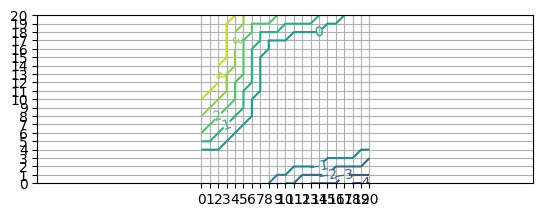

In [ ]:
import matplotlib.pylab as plt
plt.subplot(211)
CS = plt.contour(policy, levels=range(-6, 6))
plt.clabel(CS)
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.axis('equal')
plt.xticks(range(21))
plt.yticks(range(21))
plt.grid('on')

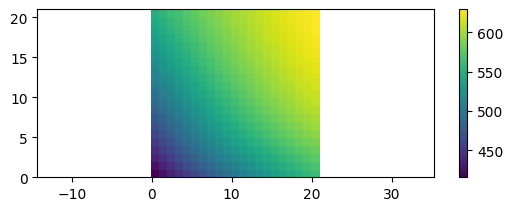

In [ ]:
plt.subplot(212)
plt.pcolor(value)
plt.colorbar()
plt.axis('equal')

plt.show()

Problem 3: Write a program for policy iteration and resolve the Gbike bicycle rental problem with the following changes.  One of your employees at the first location rides a bus home each night and lives near the second location.  She is happy to shuttle one bike to the second location for free.  Each additional bike still costs INR 2, as do all bikes moved in the other direction.  In addition, you have limited parking space at each location.  If more than 10 bikes are kept overnight at a location (after any moving of cars), then an additional cost of INR 4 must be incurred to use a second parking lot (independent of how many cars are kept there).  

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
import sys

class GbikeP:
    @staticmethod
    def max_bikes():
        return 20
    
    @staticmethod
    def γ():
        return 0.9
    
    @staticmethod
    def credit_reward():
        return 10
    
    @staticmethod
    def moving_reward():
        return -2
    
    @staticmethod
    def second_parking_lot_reward():
        return -4




class poisson_:
    
    def __init__(self, λ):
        self.λ = λ
        
        ε = 0.01
        
        # [α , β] is the range of n's for which the pmf value is above ε
        self.α = 0
        state = 1
        self.vals = {}
        summer = 0
        
        while(1):
            if state == 1:
                temp = poisson.pmf(self.α, self.λ) 
                if(temp <= ε):
                    self.α+=1
                else:
                    self.vals[self.α] = temp
                    summer += temp
                    self.β = self.α+1
                    state = 2
            elif state == 2:
                temp = poisson.pmf(self.β, self.λ)
                if(temp > ε):
                    self.vals[self.β] = temp
                    summer += temp
                    self.β+=1
                else:
                    break    
        
        # normalizing the pmf, values of n outside of [α, β] have pmf = 0
        
        added_val = (1-summer)/(self.β-self.α)
        for key in self.vals:
            self.vals[key] += added_val
        
            
    def f(self, n):
        try:
            Ret_value = self.vals[n]
        except(KeyError):
            Ret_value = 0
        finally:
            return Ret_value


#A class holding the properties of a location together
class location:
    
    def __init__(self, req, ret):
        self.α = req                             #value of lambda for requests
        self.β = ret                             #value of lambda for returns
        self.poissonα = poisson_(self.α)
        self.poissonβ = poisson_(self.β)


#Location initialisation

A = location(3,3)
B = location(4,2)


#Initializing the value and policy matrices. Initial policy has zero value for all states.

value = np.zeros((GbikeP.max_bikes()+1, GbikeP.max_bikes()+1))
policy = value.copy().astype(int)


def apply_action(state, action):
    return [max(min(state[0] - action, GbikeP.max_bikes()),0) , max(min(state[1] + action, GbikeP.max_bikes()),0)]


def expected_reward(state, action):
    global value
    """
    state  : It's a pair of integers, # of bikes at A and at B
    action : # of bikes transferred from A to B,  -5 <= action <= 5 
    """
    
    
    Reward = 0 #reward
    new_state = apply_action(state, action)    
    
    # adding reward for moving bikes from one location to another (which is negative) 
    
    if action <= 0:
        Reward = Reward + GbikeP.moving_reward() * abs(action)
    else:
        Reward = Reward + GbikeP.moving_reward() * (action - 1)    #one bike is moved by one of Jack's employees for free
    
    # adding reward for second parking lot (which is also negative)
    
    if new_state[0] > 10:
        Reward = Reward + GbikeP.second_parking_lot_reward()
        
    if new_state[1] > 10:
        Reward = Reward + GbikeP.second_parking_lot_reward()
    
    # there are four discrete random variables which determine the probability distribution of the reward and next state
    
    for Aα in range(A.poissonα.α, A.poissonα.β):
        for Bα in range(B.poissonα.α, B.poissonα.β):
            for Aβ in range(A.poissonβ.α, A.poissonβ.β):
                for Bβ in range(B.poissonβ.α, B.poissonβ.β):
                    """
                    Aα : sample of bikes requested at location A
                    Aβ : sample of bikes returned at location A
                    Bα : sample of bikes requested at location B
                    Bβ : sample of bikes returned at location B
                    TranProb  : probability of this event happening
                    """
                    
                    # all four variables are independent of each other
                    TranProb = A.poissonα.vals[Aα] * B.poissonα.vals[Bα] * A.poissonβ.vals[Aβ] * B.poissonβ.vals[Bβ]
                    
                    valid_requests_A = min(new_state[0], Aα)
                    valid_requests_B = min(new_state[1], Bα)
                    
                    rew = (valid_requests_A + valid_requests_B)*(GbikeP.credit_reward())
                    
                    #calculating the new state based on the values of the four random variables
                    new_s = [0,0]
                    new_s[0] = max(min(new_state[0] - valid_requests_A + Aβ, GbikeP.max_bikes()),0)
                    new_s[1] = max(min(new_state[1] - valid_requests_B + Bβ, GbikeP.max_bikes()),0)
                    
                    #Bellman's equation
                    Reward += TranProb * (rew + GbikeP.γ() * value[new_s[0]][new_s[1]])
                    
    return Reward


def policy_evaluation():
    
    global value
    
    # here policy_evaluation has a static variable ε whose values decreases over time
    ε = policy_evaluation.ε
    
    policy_evaluation.ε /= 10 
    
    while(1):
        δ = 0
        
        for i in range(value.shape[0]):
            for j in range(value.shape[1]):
                # value[i][j] denotes the value of the state [i,j]
                
                old_val = value[i][j]
                value[i][j] = expected_reward([i,j], policy[i][j])
                
                δ = max(δ, abs(value[i][j] - old_val))
                print(end = '')
                sys.stdout.flush()
        print(δ)
        sys.stdout.flush()
    
        if δ < ε:
            break


#initial value of ε
policy_evaluation.ε = 50


# In[13]:


def policy_improvement():
    
    global policy
    
    policy_stable = True
    for i in range(value.shape[0]):
        for j in range(value.shape[1]):
            old_action = policy[i][j]
            
            max_act_val = None
            max_act = None
            
            τ12 = min(i,5)       # if I have say 3 bikes at the first location, then I can atmost move 3 from 1 to 2
            τ21 = -min(j,5)      # if I have say 2 bikes at the second location, then I can atmost move 2 from 2 to 1
            
            for act in range(τ21,τ12+1):
                σ = expected_reward([i,j], act)
                if max_act_val == None:
                    max_act_val = σ
                    max_act = act
                elif max_act_val < σ:
                    max_act_val = σ
                    max_act = act
                
            policy[i][j] = max_act
            
            if old_action!= policy[i][j]:
                policy_stable = False
    
    return policy_stable


# In[40]:


def save_policy():
    save_policy.counter += 1
    ax = sns.heatmap(policy, linewidth=0.5)
    ax.invert_yaxis()
    plt.savefig('policy'+str(save_policy.counter)+'.svg')
    plt.close()
    
def save_value():
    save_value.counter += 1
    ax = sns.heatmap(value, linewidth=0.5)
    ax.invert_yaxis()
    plt.savefig('value'+ str(save_value.counter)+'.svg')
    plt.close()


# In[41]:


save_policy.counter = 0
save_value.counter = 0


# In[13]:


while(1):
    policy_evaluation()
    ρ = policy_improvement()
    save_value()
    save_policy()
    if ρ == True:
        break


169.90008661446765
119.08501115392248
81.88529858652572
64.74616803795342
51.78927693943169
40.39506710856131
130.22573474640814
33.99200127408341
25.5137555739268
21.803711257236273
18.193578565608277
15.003757302147903
12.324400552542386
10.109486138542536
8.287630717823049
6.791937570775872
5.565161733198636
4.559477221055772
12.962009107281688
6.645207466001352
3.646856734470475
2.4594042279098858
1.9803626503397709
1.5567917632563422
1.276453605979441
1.0510267391509274
0.8633221543227592
0.7081625047539433
0.5804264746623744
0.47550893404741146
3.2601566893927156
0.4516798693352939
0.26849425327606014
0.2197258616595832
0.17977468957758447
0.14718244083888976
0.12053995030186115
0.09872777649013642
0.08085784823032327
0.06621535006286194
0.05421864291071188
0.04439153050952882
0.054351854527794785
0.029752586396000424
0.024359821261725756
0.019954981657292592
0.016351527617814554
0.013396957785914765
0.010973020080939477
0.008985450206978385
0.007356772277660184
0.006022793419617

In [ ]:
print(policy)


[[ 0  0  0  0  0  0  0 -1 -1 -2 -2 -3 -3 -3 -4 -5 -4 -4 -5 -5 -5]
 [ 1  0  0  0  0  0  0  0 -1 -1 -2 -2 -2 -3 -4 -5 -3 -4 -4 -4 -4]
 [ 1  1  0  0  0  0  0  0  0 -1 -1 -1 -2 -3 -4 -5 -3 -3 -3 -3 -3]
 [ 1  1  1  1  0  0  0  0  0  0  0 -1 -2 -3 -4 -5 -2 -2 -2 -2 -2]
 [ 1  1  1  1  1  0  0  0  0  0  0 -1 -2 -3 -4 -1 -1 -1 -1 -1 -1]
 [ 1  1  1  1  1  1  0  0  0  0  0 -1 -2 -3  0  0  0  0  0  0  0]
 [ 2  1  1  1  1  1  1  1  0  0  0 -1 -2  0  0  0  0  0  0  0  0]
 [ 2  2  1  1  1  1  1  1  1  0  0 -1 -2  0  0  0  0  0  0  0  0]
 [ 3  2  2  1  1  1  1  1  1  1  0 -1  0  0  0  0  0  0  0  0  0]
 [ 3  3  2  2  1  1  1  1  1  1  0 -1  0  0  0  0  0  0  0  0  0]
 [ 4  3  3  2  1  1  1  1  1  1  0  1  0  0  0  0  0  0  0  0  0]
 [ 4  4  3  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 5  4  3  3  2  2  2  2  2  1  0  2  2  2  2  2  2  2  2  2  2]
 [ 5  4  4  3  3  3  3  3  1  1  0 -1  3  3  3  3  3  3  1  1  0]
 [ 5  5  4  4  4  4  4  1  1  1  0 -1  1  1  1  1  1  1  1  1  0]
 [ 5  5  5

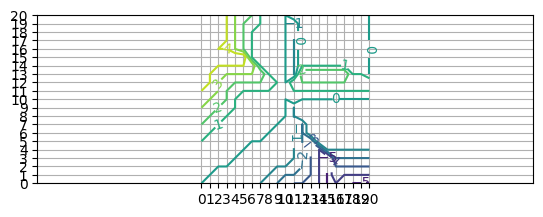

In [ ]:
import matplotlib.pylab as plt
plt.subplot(211)
CS = plt.contour(policy, levels=range(-6, 6))
plt.clabel(CS)
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.axis('equal')
plt.xticks(range(21))
plt.yticks(range(21))
plt.grid('on')

[[424.19796165 434.16553558 444.00110203 453.55492055 462.69162764
  471.33817161 479.48406054 487.36617336 495.02869112 502.51584579
  509.69887606 516.48006927 523.14646075 529.3557282  535.07809014
  539.96183236 541.7072184  546.26923062 550.42497035 554.29037881
  557.79786623]
 [434.16573154 444.06080717 453.89599821 463.44861281 472.58290661
  481.22572046 489.36666085 497.02917689 504.51632403 511.69935164
  518.48045917 525.14684835 531.35611345 537.0783509  541.96197933
  546.11804482 548.26948554 552.42511405 556.29052119 559.79800725
  563.02292781]
 [444.06135365 453.89650413 463.45916784 473.00662959 482.13100087
  490.75858538 498.87928943 506.51701949 513.70004284 520.4810814
  527.14746691 533.35672839 539.07882242 543.96228265 548.11820862
  551.63978449 554.42541121 558.2908159  561.7982995  565.02321784
  568.01463654]
 [453.62658203 463.45980785 473.00727664 482.13169501 491.1107018
  499.70486906 507.78097462 515.36389902 522.48177011 529.14815165
  535.35740914 5

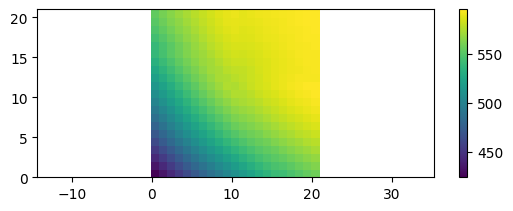

In [ ]:
plt.subplot(212)
plt.pcolor(value)
print(value)
plt.colorbar()
plt.axis('equal')

plt.show()